## Python examples in Sambridge et al. (2022): Point masses

This Jupyter notebook contains Python code to illustrate calculations made in 

Sambridge, Jackson & Valentine (2022), [Geophysical Inversion and Optimal Transport](https://doi.org/10.1093/gji/ggac151), *Geophysical Journal International*.



Here calculations demonstrating the steps involved in construction of Wasserstein distances between point mass distributions in Figure 5 of the paper are demonstrated.

In [1]:
import numpy as np
from libs import OTlib as OT       # This is provided as part of the package
import matplotlib.pyplot as plt
from matplotlib import cm
import bisect
from scipy.interpolate import UnivariateSpline

#### Point masses

An illustrative example in Figure 5 of Sambridge et al. (2022) shows a worked example of the calculation of the Wasserstein distance for a problem involving six point masses. 

The initial/source set of point passes have locations $$x_i = 3 + 2.2\times(i-1), \quad (i=1,\dots,6),$$
and weights $$ (f_1, f_2,\dots,f_6) = (0.2, 0.01, 0.18, 0.21, 0.2, 0.2)$$.

While the final/target set of point passes have locations $$x_i = 7 + 2.2\times(i-1), \quad (i=1,\dots,6),$$
and weights $$ (g_1, g_2,\dots,g_6) = (0.18, 0.07, 0.02, 0.05, 0.27, 0.23).$$


In [2]:
# set up initial and final PDFs simple point masses
fx = np.linspace(3, 14, 6)
gx = np.linspace(7, 18, 6)
f = np.array([0.2,0.01,0.18,0.21,0.2,0.2])   # initial distribution is two Gaussians
g = np.array([0.18,0.07,0.2,0.05,0.27,0.23]) # final distribution is one Gaussian with same sum as f

Here we plot the point masses.

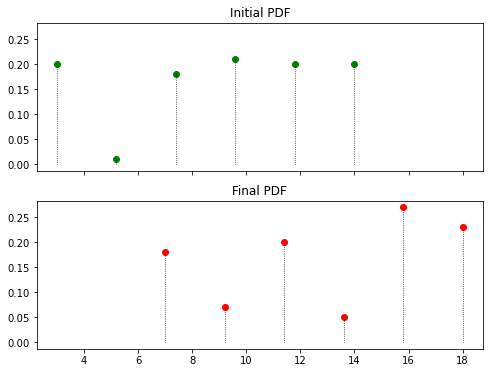

In [3]:
# plot PDFs
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True,figsize=(8,6))
ax[0].set_title('Initial PDF')
ax[0].plot(fx,f,'go',lw=0.7)
for i in range(len(fx)):
    ax[0].plot([fx[i],fx[i]],[0.,f[i]],'k:',lw=0.7)
ax[1].plot(gx,g,'ro',lw=0.7)
for i in range(len(gx)):
    ax[1].plot([gx[i],gx[i]],[0.,g[i]],'k:',lw=0.7)
ax[1].set_title('Final PDF')
plt.savefig('Figures/Initial_final_pointmasses.pdf')
plt.show()

In [4]:
# set up PDF objects
source = OT.OTpdf((f,fx)) # set up source object
target = OT.OTpdf((g,gx)) # set up target object

Below we demonstrate elements required in the calculation of the Wasserstein distance between two sets of point masses, $f$ and $g$, via six different plots. These are:
- The cummulative distribution functions, CDFs
$$F(x) = \int_{-\infty}^x f(x^{\prime}) dx^{\prime},\quad G(x) = \int_{-\infty}^x g(x^{\prime}) dx^{\prime}$$.
- The inverse cummulative distribution functions, e.g.
$$ F^{-1}(t),\quad  {\rm where},\quad t = F(x)$$.
- The difference between the inverse cummulative distribution functions,
$ | F^{-1}(t) - G^{-1}(t)|$.
- The square of the difference between the inverse cummulative distribution functions,
$ | F^{-1}(t) - G^{-1}(t)|^2$.
- The piecewise constant Transport map, $$T(x) = G^{-1}(F(x))$$.
- The square of the difference between the Transport map, $T(x)$ and $x$, $|x-T(x)|^2$, i.e. blue and dashed lines in previous plot.

Panels 1,2,3 and 5 are shown in Figure 5 of Sambridge et al. (2022).

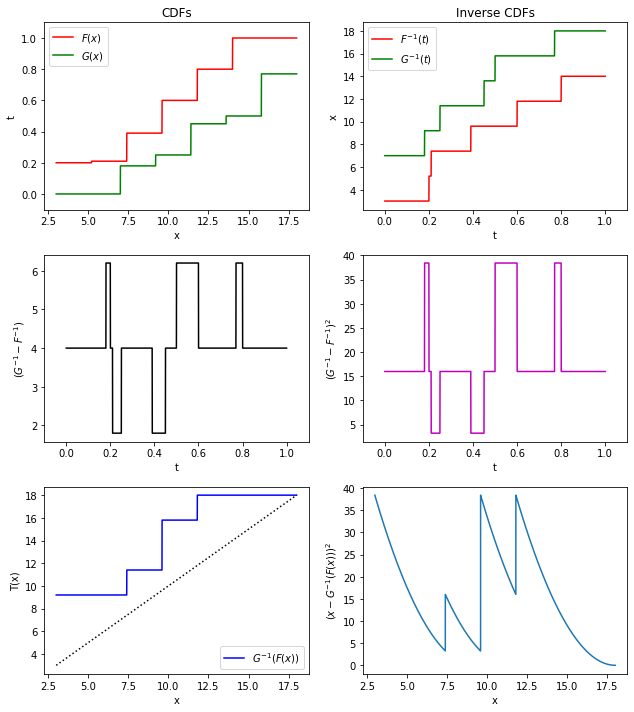

In [5]:
# Calculate a plot demonstrating Wasserstein calculation for point masses
if(True):
    nx=10000 # plot discretization 
    cf = source.cdf # Cumulative distribution of source point mass
    cg = target.cdf # Cumulative distribution of target point mass
    
    start = np.min((fx[0],gx[0]))+0.5*(np.max((fx[-1],gx[-1])-np.min((fx[0],gx[0]))))/nx 
    stop = np.max((fx[-1],gx[-1]))-0.5*(np.max((fx[-1],gx[-1])-np.min((fx[0],gx[0]))))/nx 
    x = np.linspace(start,stop,nx)   # x-axis evaluation points for plot
    t = np.linspace(0,1,nx)          # t-axis evaluation points for plot

    F = np.dot(f,np.transpose(list(map(lambda x: np.heaviside(x-fx,0.0), x)))) #cdf of f
    G = np.dot(g,np.transpose(list(map(lambda x: np.heaviside(x-gx,0.0), x)))) #cdf of g

    Fp = np.append(F,1.0) # tidy up upper end point for neatness of plot
    Gp = np.append(G,1.0) # tidy up upper end point for neatness of plot
    xp = np.append(x,np.max((fx[-1],gx[-1])))
    Fp = F
    Gp = G
    xp = x

    dfx = fx[1:]-fx[:-1] 
    IF = fx[0] + np.dot(dfx,np.transpose(list(map(lambda x: np.heaviside(x-cf[:-1],0.0), t))))
    dgx = gx[1:]-gx[:-1]
    IG = gx[0] + np.dot(dgx,np.transpose(list(map(lambda x: np.heaviside(x-cg[:-1],0.0), t))))
    iFGdiff = IF-IG # Difference in inverse Cummulative functions
    IGF = gx[0] + np.dot(dgx,np.transpose(list(map(lambda x: np.heaviside(x-cg[:-1],0.0), F))))
    xmIFGsq = np.multiply(x - IGF,x - IGF)

    OT.plotWasser(xp,Fp,Gp,t,IF,IG,x,IGF,xmIFGsq,iFGdiff,filename='Figures/pointmass_calculations.pdf')

This should look like FIgure 5 of the paper.

The Wasserstein distance between these two distributions $W_1$ can be calculated using the OT library:

In [6]:
print('W_1 = ',np.round(OT.wasser(source,target,distfunc='W1')[0],4))

W_1 =  4.11


The Wasserstein distance between these two distributions $W^2_2$ can be calculated using the OT library:

In [7]:
print('W_2 = ',np.round(OT.wasser(source,target,distfunc='W2')[0],4))

W_2 =  18.09
